For each practical exercise (TP), please work in groups of two or three. Then, create a **private GitHub repository** and add me (my GitHub is **arthur-75**) to your project. Finally, share the link to your project (or TP) under  [Practical Exercises](https://docs.google.com/spreadsheets/d/1V-YKgHn71FnwjoFltDhWsPJS7uIuAh9lj6SP2DSCvlY/edit?usp=sharing) and make sure to choose your **team name** :-)

# **Conditional WGAN-GP on CelebA**

## **1\. Conditional GANs**

A **Conditional GAN** is a variant of GANs where we **condition** both the **generator** and **critic** (discriminator) on **label information**. Instead of generating arbitrary images, we can **instruct** the GAN to generate images from a specific class or with a specific attribute (e.g., “Blond\_Hair” \= 0 or 1).

### **What’s Different from a Standard GAN?**

* You pass the **label** into both the **generator** and the **critic**.  
* The generator learns to produce images that **match** that label.  
* The critic can check if an image **matches** the label (i.e., it sees both the image and the label together).

In [2]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# -----------------------------
#  HYPERPARAMETERS
# -----------------------------
IMAGE_SIZE = 64       # Image height/width
CHANNELS = 3          # Using color images
LABEL_DIM = 2         # e.g. "Blond_Hair" => 2 classes: 0 or 1
BATCH_SIZE = 128
Z_DIM = 32            # Dimension of noise
LEARNING_RATE = 0.00005
BETA1 = 0.5
BETA2 = 0.999
EPOCHS = 20
CRITIC_STEPS = 3      # Number of critic iterations per generator iteration
GP_WEIGHT = 10.0      # Gradient penalty lambda

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## **2\. Prepare the Dataset**

1. **Collect** your images (e.g., CelebA).  
2. **Resize** them to a consistent size (e.g. 64×64).  
3. **Normalize** them to \[−1,1\] if you use **tanh** in the generator.  
4. For **each** image, figure out its **label** (e.g., “Blond\_Hair” \= 0 or 1).  
5. In your DataLoader, return **(image, label)** pairs.


In [6]:

# CSV that contains attributes (e.g., 'Blond_Hair')
ATTR_CSV = "~/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/list_attr_celeba.csv"
df = pd.read_csv(ATTR_CSV)

# Suppose you want the attribute 'Blond_Hair' as a binary label: 0 or 1
LABEL = "Blond_Hair" 

# Convert from [-1, +1] to [0, 1]
df[LABEL] = df[LABEL].apply(lambda x: 1 if x == 1 else 0)

# 'image_id' column has filenames like "000001.jpg", "000002.jpg", etc.
img_fnames = df["image_id"].tolist()
labels = df[LABEL].tolist()

# For example, confirm the first 5 filenames & labels
print(img_fnames[:5])
print(labels[:])
df.head()


['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [19]:

# -----------------------------
#   DATASET (Conditional)
# -----------------------------
class CelebAConditionalDataset(Dataset):
    """
    A simple dataset that returns (image, label) pairs.
    'label' is expected to be 0 or 1 for the chosen attribute.
    """
    def __init__(self, root_dir, img_fnames, labels, transform=None):
        """
        root_dir: Folder with images
        img_fnames: List of image file names
        labels: List of 0/1 labels
        transform: Torchvision transforms
        """
        self.root_dir = root_dir
        self.img_fnames = img_fnames
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_fnames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.img_fnames[idx])
        image = torchvision.io.read_image(img_path)  # shape: (C, H, W), 0-255
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)  # e.g. resizing, normalization

        return image, label


# Example transform: resize, convert to [-1,1]
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

root_dir = "~/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2/img_align_celeba"  # TODO: Change to your actual path
dataset = torchvision.datasets.ImageFolder(root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


## **3\. Conditional Critic (Discriminator)**

1. **Concatenate** the label with the image. For example:  
   * If the image is (3,64,64)(RGB) and label is \[0,1\] replicate label across 64×64 to get a shape (2,64,64).  
   * Then **cat** them along the channel dimension → (3+2,64,64).  
2. **Downsample** this combined input with convolution layers to get a **single scalar output**.  
3. **No Sigmoid** is required if using **Wasserstein** approach.


In [20]:

# -----------------------------
#   CONDITIONAL CRITIC (Discriminator)
# -----------------------------
class ConditionalCritic(nn.Module):
    """
    Critic for Conditional WGAN-GP.
    - Takes (image, label) pairs.
    - Labels are expanded to match image spatial dimensions and concatenated to input.
    """

    def __init__(self, img_channels=3, label_dim=2, base_features=64):
        super().__init__()
        self.img_channels = img_channels
        self.label_dim = label_dim

        self.model = nn.Sequential(
            # Input: (img_channels=3 + label_dim=2, base_features=64)
            nn.Conv2d(3 + 2, 64, kernel_size=4, stride=2, padding=1),#3 couleurs, deux classes
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_features, base_features * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_features * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Dropout(0.3),

            nn.Conv2d(base_features * 2, base_features * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_features * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Dropout(0.3),

            nn.Conv2d(base_features * 4, base_features * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_features * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Dropout(0.3),

            # Final output: (B, 1, 1, 1) → Flatten to (B, 1)
            nn.Conv2d(base_features * 8, 1, kernel_size=4, stride=1, padding=0),
            nn.Flatten(start_dim=1)
        )

    def forward(self, image, label):
        """
        image: (B, 3, 64, 64)
        label: (B,) or (B,1) or (B,2)
        - Ensure label is one-hot: shape (B, label_dim).
        - Expand to (B, label_dim, 64, 64) and concatenate with image.
        """
        if label.dim() == 1 or label.shape[1] == 1:  # If not one-hot
            label = F.one_hot(label.long(), num_classes= self.label_dim ).float()

        # Expand label across spatial dimensions
        bsz = label.size(0)
        label_img = label.view(bsz, self.label_dim, 1, 1).repeat(1, 1, IMAGE_SIZE, IMAGE_SIZE)  # (B, label_dim, 64, 64)

        concat_input = torch.cat([image, label_img], dim=1)  # (B, img_channels + label_dim, 64, 64)
        return self.model(concat_input)


## **4\. Conditional Generator**

1. **Concatenate** the **noise vector** (z) with the label.  
2. Reshape to (z\_dim  \+ label\_dim,1,1).  
3. Use `ConvTranspose2d` layers (also called **deconvolution**) to **upsample** from (z\_dim+label\_dim,1,1) to (3,64,64).  
4. Output activation \= **tanh** to produce images in \[−1,1\].


In [21]:

# -----------------------------
#  CONDITIONAL GENERATOR
# -----------------------------
class ConditionalGenerator(nn.Module):
    """
    Generator for Conditional WGAN-GP.
    - Concatenates noise vector z and one-hot label.
    - Reshapes input to (B, z_dim + label_dim, 1,1).
    - Uses ConvTranspose2d layers to upsample to (B, 3, 64, 64).
    """

    def __init__(self, z_dim=32, label_dim=2, img_channels=3, base_features=64):
        super().__init__()
        self.z_dim = z_dim
        self.label_dim = label_dim

        self.model = nn.Sequential(
            # Input: (z_dim + label_dim, 1, 1)
            nn.ConvTranspose2d(Z_DIM + 2, base_features * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(base_features * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(base_features * 8, base_features * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base_features * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(base_features * 4, base_features * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base_features * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(base_features * 2, base_features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base_features),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(base_features, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Output range: [-1, 1]
        )

    def forward(self, noise, label):
        """
        noise: (B, z_dim, 1, 1)
        label: (B,) or (B,1) or (B,2)
        - Convert label to one-hot if necessary.
        - Reshape label to (B, label_dim, 1,1) and concatenate with noise.
        """
        if label.dim() == 1 or label.shape[1] == 1:  # If not one-hot
            label = F.one_hot(label.long(), num_classes=self.label_dim).float()

        bsz = label.size(0)
        label_img = label.view(bsz, self.label_dim, 1, 1)  # (B, label_dim, 1,1)

        z_cat = torch.cat([noise, label_img], dim=1)  # (B, z_dim + label_dim, 1,1)
        return self.model(z_cat)




## **5\. Conditioning in Both Networks**

* **Critic** sees:  
  * (image,label)  →  critique score  
* **Generator** sees:  
  * (noise,label)  →  image

This ensures the generator **knows** which label it’s trying to produce, and the critic **checks** if the image is **real** *and* **matches** the label.


In [22]:
# -----------------------------
#   INITIALIZE MODELS
# -----------------------------
critic = ConditionalCritic(img_channels=CHANNELS, label_dim=LABEL_DIM, base_features=64).to(DEVICE)
generator = ConditionalGenerator(z_dim=Z_DIM, label_dim=LABEL_DIM, img_channels=CHANNELS, base_features=64).to(DEVICE)

print("Conditional Critic and Generator successfully initialized!")

Conditional Critic and Generator successfully initialized!



## **6\. Loss & Training (WGAN-GP Style)**

1. **Critic Loss**:

   * Loss \= E\[critic(fake,label)\]  −  E\[critic(real,label)\]  +  λ⋅GP

   * Where **GP** \= Gradient Penalty (regularizing the critic’s gradient norm).

2. **Generator Loss**:

   * loss= − E\[critic(fake,label)\]

   * Encourages the generator to produce images that the critic scores as **highly real**.


In [23]:


# -----------------------------
#   OPTIMIZERS
# -----------------------------
critic_optimizer = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
generator_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))


# -----------------------------
#   HELPER FUNCTION: Gradient Penalty
# -----------------------------
def gradient_penalty(critic, real_imgs, fake_imgs, labels, device=DEVICE):
    """
    Compute gradient penalty for WGAN-GP in a conditional setting:
    1. Interpolate real & fake => interpolated
    2. Critic(interpolated, label)
    3. Penalty if norm-1 != 0
    """
    bsz, C, H, W = real_imgs.shape
    alpha = torch.rand(bsz, 1, 1, 1, device=device).expand(bsz, C, H, W)

    interpolated = real_imgs * alpha + fake_imgs * (1 - alpha)
    interpolated.requires_grad_(True)

    # Forward pass of critic
    # We replicate label to match shape
    critic_score = critic(interpolated, labels)

    # Take gradient w.r.t. interpolated
    grad = torch.autograd.grad(
        inputs=interpolated,
        outputs=critic_score,
        grad_outputs=torch.ones_like(critic_score),
        create_graph=True,
        retain_graph=True
    )[0]  # shape => (bsz, C, H, W)

    grad = grad.view(bsz, -1)  # flatten
    grad_norm = grad.norm(2, dim=1)  # L2 norm per sample

    gp = torch.mean((grad_norm - 1)**2)
    return gp


## **7\. Training Loop**

1. **For each epoch**:  
   1. For each batch of (real\_image,label)(real\_image,label):  
      * **Train Critic**:  
        1. Generate fake images using (noise,label)(noise,label).  
        2. Compute **critic loss** (real vs. fake, plus GP).  
        3. **Backprop** \+ **update** critic.  
      * **Train Generator** (once after several critic updates):  
        1. Generate new fake images.  
        2. Compute **generator loss** (wants to fool critic).  
        3. **Backprop** \+ **update** generator.


In [24]:

# -----------------------------
#   TRAINING LOOP
# -----------------------------
print("Starting conditional WGAN-GP training!")
g_losses, c_losses = [], []

for epoch in range(EPOCHS):
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch_idx, (real_images, labels) in progress_bar:
        real_images = real_images.to(DEVICE)
        labels = labels.to(DEVICE)
        cur_bsz = real_images.size(0)

        # -----------------------------
        # (a) Train Critic multiple steps
        # -----------------------------
        for _ in range(CRITIC_STEPS):
            noise = torch.randn(cur_bsz, Z_DIM, 1, 1, device=DEVICE)
            fake_images = generator(noise, labels)

            critic_optimizer.zero_grad()

            critic_real = critic(real_images, labels).view(-1)
            critic_fake = critic(fake_images, labels).view(-1)

            wass_distance = (torch.mean(critic_fake) - torch.mean(critic_real))

            gp = gradient_penalty(critic, real_imgs=real_images, fake_imgs=fake_images, labels=labels, device=DEVICE)
            critic_loss = wass_distance + GP_WEIGHT*gp

            critic_loss.backward(retain_graph=True)
            critic_optimizer.step()

        # -----------------------------
        # (b) Train Generator
        # -----------------------------
        generator_optimizer.zero_grad()
        critic_fake_for_g = critic(fake_images, labels).view(-1)
        gen_loss = -torch.mean(critic_fake_for_g)
        gen_loss.backward()
        generator_optimizer.step()

        c_losses.append(critic_loss.item())
        g_losses.append(gen_loss.item())

        progress_bar.set_postfix({
            "C_Loss": f"{critic_loss.item():.4f}",
            "GP": f"{gp.item():.4f}",
            "WassDist": f"{wass_distance.item():.4f}",
            "G_Loss": f"{gen_loss.item():.4f}"
        })



Starting conditional WGAN-GP training!


Epoch 20/20: 100%|██████████| 1583/1583 [09:35<00:00,  2.75it/s, C_Loss=-4.2011, GP=0.1045, WassDist=-5.2459, G_Loss=83.7226]      




If dose work then you can use a pre-trained model:


In [25]:
GEN_PATH = "tp2-3_conditional_generator.pth"
CRITIC_PATH = "tp2-3_conditional_discriminator.pth"

# Load state dictionaries
generator.load_state_dict(torch.load(GEN_PATH, map_location=DEVICE))
critic.load_state_dict(torch.load(CRITIC_PATH, map_location=DEVICE))
generator.eval()
critic.eval()

/tmp/ipykernel_70118/12076632.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(GEN_PATH, map_location=DEVICE))
/tmp/ipykernel_70118/1

ConditionalCritic(
  (model): Sequential(
    (0): Conv2d(5, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout(p=0.3, inplace=False)
    (14): Conv2d(512, 1, kernel_size=(4, 4), stride


## **8\. Monitoring Progress**

1. **Plot** Critic Loss and Generator Loss over time.  
2. Occasionally **sample** random noise (and label) → generate images.  
3. See if the generated images match the label condition.


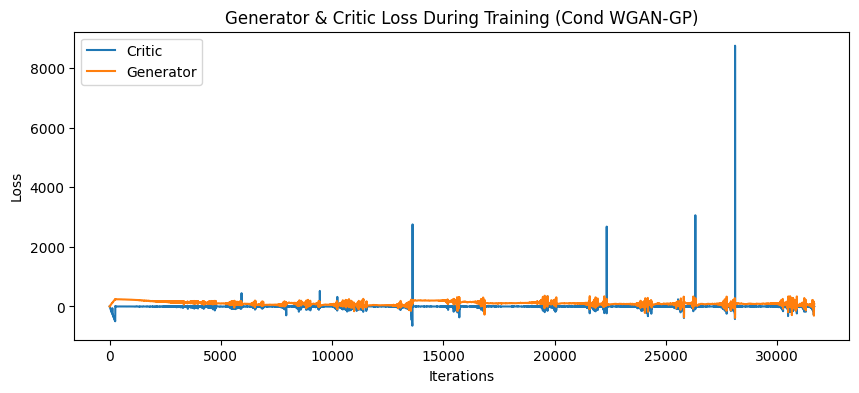

In [26]:
# -----------------------------
#   Plot losses
# -----------------------------
def plot_losses(g_losses, c_losses):
    plt.figure(figsize=(10,4))
    plt.title("Generator & Critic Loss During Training (Cond WGAN-GP)")
    plt.plot(c_losses, label="Critic")
    plt.plot(g_losses, label="Generator")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_losses(g_losses, c_losses )


## **9\. Generating Images with a Chosen Label**

* After training, pick a label (e.g., `label=1`).  
* Sample noise z.  
* Generate an image via Generator(z,label)Generator(z,label).  
* Inspect if the attribute or class you chose is visible in the generated result.


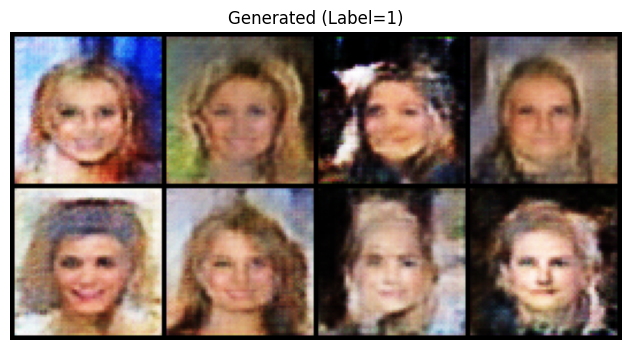

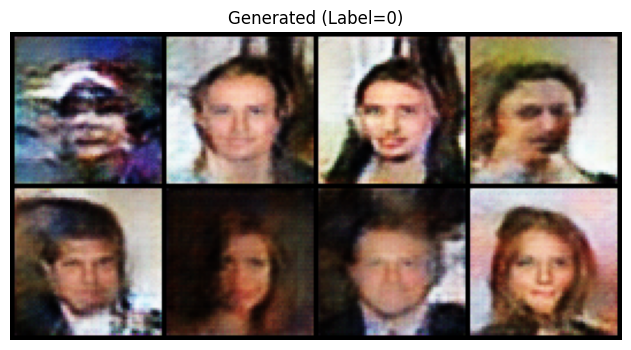

In [27]:

# -----------------------------
#   Generate
# -----------------------------
def generate_samples(generator, label, num_samples=8):
    """
    label: int or 0/1 (or a batch of them). 
    We'll produce 'num_samples' images for the specified label 
    and display them in a grid.
    """
    generator.eval()
    noise = torch.randn(num_samples, Z_DIM, 1, 1).to(DEVICE)

    label_tensor = torch.tensor([label]*num_samples, device=DEVICE)
    # If it's a 2-class attribute, we can do a one-hot if needed:
    # label_tensor = F.one_hot(label_tensor, num_classes=2).float()
    # For simplicity, assume we already are passing 0 or 1 => one-hot?

    with torch.no_grad():
        fake_imgs = generator(noise, label_tensor)
    fake_imgs = fake_imgs.cpu()*0.5 + 0.5

    grid_img = torchvision.utils.make_grid(fake_imgs, nrow=4)
    plt.figure(figsize=(8,4))
    plt.imshow(grid_img.permute(1,2,0).numpy())
    plt.axis("off")
    plt.title(f"Generated (Label={label})")
    plt.show()
    generator.train()

# If you have a trained model:
generate_samples(generator, label=1, num_samples=8)
generate_samples(generator, label=0, num_samples=8)

## **10\. Improving the Model (optional)**

* **Use More Classes**: Instead of 0/1, you can have multi-class labels (e.g., hair color with 4 or 5 categories).  
* **Add More Convolutional Depth**: For sharper images, add more layers or bigger feature maps.  
* **Change Image Size**: If you have enough GPU memory, use 128×128 or 256×256.  
* **Try Different Normalization**: E.g., **Spectral Norm** in the critic.
